In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
import torch
import torchvision.transforms.functional as FT
from PIL import Image
import cv2
import os
import math
from torchvision.ops.boxes import box_iou
from collections import defaultdict
# http://www.robots.ox.ac.uk/~vgg/software/via/via-1.0.6.html

In [2]:
def process_bbox(df):
    df['bbox'] = df['region_shape_attributes'].apply(lambda x: eval(x))
    df['x'] = df['bbox'].apply(lambda x: x['x'])
    df['y'] = df['bbox'].apply(lambda x: x['y'])
    df['w'] = df['bbox'].apply(lambda x: x['width'])
    df['h'] = df['bbox'].apply(lambda x: x['height'])
    df['x'] = df['x'].astype(np.float)
    df['y'] = df['y'].astype(np.float)
    df['w'] = df['w'].astype(np.float)
    df['h'] = df['h'].astype(np.float)

    df.drop(columns=['bbox'], inplace=True)
    #     df.reset_index(drop=True)
    return df

In [3]:
csv_path = '/home/jake/PycharmProjects/balloon_detection/ballon_datasets/via_region_data_TEST_70.csv'

path ='/home/jake/PycharmProjects/balloon_detection/ballon_datasets/TEST/'
weight_path = '/home/jake/PycharmProjects/balloon_detection/weights/best_fasterrcnn_resnet50_fpn.pth'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"
input_size=300
df = pd.read_csv(csv_path)
df = process_bbox(df)
#image_id = '485227412_e335662bb5_b.jpg'
len(df)

67

# predict

In [42]:
def make_true_boxes(df,image_num):
    ifprint = False
    x = df[df['#filename'] == df['#filename'][image_num]]['x'].values
    y = df[df['#filename'] == df['#filename'][image_num]]['y'].values
    w = df[df['#filename'] == df['#filename'][image_num]]['w'].values
    h = df[df['#filename'] == df['#filename'][image_num]]['h'].values


    true_boxes = []
    for i in range(len(x)):
        true_boxes.append([x[i], y[i], x[i] + w[i], y[i] + h[i]])
        
        
    path ='/home/jake/PycharmProjects/balloon_detection/ballon_datasets/TEST/'
    img = cv2.imread(path + df['#filename'][image_num])
    original_size =img.shape[0]
    true_boxes = []
    if ifprint:print('original->',original_size,'input_size->',input_size)
    #new_scale = input_size/original_size
    #new_scale = original_size/input_size
    new_scale = input_size/input_size
    
        #print(x,y,w,h)
    if ifprint:print("======================================================================")
    if ifprint:print('make_true_boxes_new_scale')
    if ifprint:print('x->{},y->{},w->{},h->{}, input_size->{}, original_>{}'.format(x,y,w,h,input_size,original_size))

    for i in range(len(x)):
        #new_x = x[i] * (input_size / w[i])
        #new_y = y[i] * (input_size / h[i])
        #new_w = input_size
        #new_h = input_size

        new_x = x[i] * new_scale
        new_y = y[i] * new_scale
        new_w  = w[i] * new_scale
        new_h = h[i] * new_scale
        
        true_boxes.append([new_x,new_y,new_x+new_w, new_y+new_h])
    if ifprint:print('true_boxes->',true_boxes)
    return torch.tensor(true_boxes)

def make_true_boxes_new_scale(df,image_num):
    ifprint= False
    x = df[df['#filename'] == df['#filename'][image_num]]['x'].values
    y = df[df['#filename'] == df['#filename'][image_num]]['y'].values
    w = df[df['#filename'] == df['#filename'][image_num]]['w'].values
    h = df[df['#filename'] == df['#filename'][image_num]]['h'].values
    if ifprint: print("======================================================================")
    if ifprint:print('make_true_boxes_new_scale')
    if ifprint:print('x->{},y->{},w->{},h->{}, input_size->{}, original_>{}'.format(x,y,w,h,input_size,original_size))
    
    
      #print(x,y,w,h)
        
    true_boxes = []
    for i in range(len(x)):
        true_boxes.append([(x[i]*(input_size/w[i])),
                           y[i]*(input_size/h[i]),
                           (x[i]*(input_size/w[i])) + input_size, 
                           (y[i]*(input_size/h[i])) + input_size])

    

        
    if ifprint:print(true_boxes)
    return torch.tensor(true_boxes)

def image_show(img_path,file_num,df,boxes,real,input_size):
    ifprint = False
    #print(df)
    img_path =path +df['#filename'][file_num]
    #print('image_path->',img_path)

    #print('img_path->',img_path)
    image_arr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_arr /= 255.0
    
    
    new_image = FT.to_tensor(image_arr)
    new_image = FT.to_pil_image(new_image)
    new_image = FT.resize(new_image, (input_size,input_size))
    new_image = FT.to_tensor(new_image)
    new_image = FT.to_pil_image(new_image)
    #plt.imshow(new_image)
    
    #image_arr = new_image
    box_true=make_true_boxes(df,file_num)
    
    #print('new_image_shape->',np.array(new_image).shape)
    #print('make_true_boxes->',box_true)

    
    #print(image_arr.shape,image.shape)
    color = (0,255,0)
    thickness = 1
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    #print('boxes->',boxes)
    
    height = np.array(image_arr).shape[1]
    width = np.array(image_arr).shape[0]
    old_dims = torch.FloatTensor([width, height,width,height]).unsqueeze(0)
    new_dims =  torch.FloatTensor([input_size, input_size, input_size, input_size]).unsqueeze(0)
    #print('old_dims->{}, new_dims->{}'.format(old_dims,new_dims))
    #new_boxes=boxes/old_dims
    #print('old_dims->',old_dims)
    #print('new_dims->',new_dims)
    new_boxes = boxes * (new_dims/old_dims)
    #if ifprint:print('new_boxes->{} , image_size->{}'.format(new_boxes,np.array(new_image).shape))
    #print('old_boxes->>>>',boxes)
    #print('new_boxes->>>>>',new_boxes)
    #new_boxes = boxes

    #print('new_dims/old_dims->',new_dims/old_dims)
    #print('box_true->',box_true * (new_dims/old_dims))
    #print('new_boxes->',new_boxes)
    
    new_img = np.array(new_image)
    orig_img = np.array(image_arr)
    
    if real:
        #print('old_box[][][][]',boxes)
        boxs = boxes
        img = orig_img
        thickness = 3
        color = (0,0,255)
    else:
        #print('new_box[][][][]',new_boxes)
        boxs = new_boxes
        img = new_img
        thickness = 2
        color = (255,0,0)
    
    for box in boxs:
        #print('box->',box)
        #rem = 1
        #print(np.array(img).shape)
        cv2.rectangle(img,(int(box[0]),int(box[1])), ((int(box[2])), int(box[3])),color, thickness)
        #cv2.rectangle(orig_img,(0,400),(500,1000),color, thickness)
    #print('image->',np.array(orig_img).shape)
    ax.set_axis_off()
    ax.imshow(img)
    #plt.imshow(orig_img)

# original prediction

In [43]:
df

#filename  file_size file_attributes  region_count  region_id  \
0   new_002.jpg       6501              {}             3          0   
1   new_002.jpg       6501              {}             3          1   
2   new_002.jpg       6501              {}             3          2   
3    new003.jpg      17426              {}             3          0   
4    new003.jpg      17426              {}             3          1   
..          ...        ...             ...           ...        ...   
62  3333333.jpg       5095              {}             6          1   
63  3333333.jpg       5095              {}             6          2   
64  3333333.jpg       5095              {}             6          3   
65  3333333.jpg       5095              {}             6          4   
66  3333333.jpg       5095              {}             6          5   

                              region_shape_attributes region_attributes  \
0   {"name":"rect","x":24,"y":32,"width":71,"heigh...                {}   
1   {"name":"rect","x":83,"y":18,"width":60,"heigh...                {}   
2   {"name":"rect","x":129,"y":28,"width":72,"heig...                {}   
3   {"name":"rect","x":66,"y":15,"width":102,"heig...                {}   
4   {"name":"rect","x":43,"y":103,"width":70,"heig...                {}   
..                                                ...               ...   
62  {"name":"rect","x":17,"y":141,"width":68,"heig...                {}   
63  {"name":"rect","x":93,"y":118,"width":65,"heig...                {}   
64  {"name":"rect","x":143,"y":74,"width":54,"heig...                {}   
65  {"name":"rect","x":93,"y":63,"width":46,"heigh...                {}   
66  {"name":"rect","x":59,"y":92,"width":66,"heigh...                {}   

        x      y      w     h  
0    24.0   32.0   71.0  78.0  
1    83.0   18.0   60.0  88.0  
2   129.0   28.0   72.0  85.0  
3    66.0   15.0  102.0  89.0  
4    43.0  103.0   70.0  96.0  
..    ...    ...    ...   ...  
62   17.0  141.0   68.0  75.0  
63   93.0  118.0   65.0  63.0  
64  143.0   74.0   54.0  86.0  
65   93.0   63.0   46.0  65.0  
66   59.0   92.0   66.0  58.0  

[67 rows x 11 columns]

In [44]:
df[df['#filename'] == df['#filename'][0]][['#filename','x','y','w','h']]

#filename      x     y     w     h
0  new_002.jpg   24.0  32.0  71.0  78.0
1  new_002.jpg   83.0  18.0  60.0  88.0
2  new_002.jpg  129.0  28.0  72.0  85.0

In [45]:
df['#filename'][0]

'new_002.jpg'

In [46]:
df[df['#filename']=='new_002.jpg']

#filename  file_size file_attributes  region_count  region_id  \
0  new_002.jpg       6501              {}             3          0   
1  new_002.jpg       6501              {}             3          1   
2  new_002.jpg       6501              {}             3          2   

                             region_shape_attributes region_attributes      x  \
0  {"name":"rect","x":24,"y":32,"width":71,"heigh...                {}   24.0   
1  {"name":"rect","x":83,"y":18,"width":60,"heigh...                {}   83.0   
2  {"name":"rect","x":129,"y":28,"width":72,"heig...                {}  129.0   

      y     w     h  
0  32.0  71.0  78.0  
1  18.0  60.0  88.0  
2  28.0  72.0  85.0

In [47]:
df[df['#filename']=='imagessdfsdf.jpg'].index[0]

7

In [48]:
img = cv2.imread(path + '3333333.jpg')  
img.shape

(225, 225, 3)

In [49]:
df[df['#filename'] == df['#filename'][0]].index

Int64Index([0, 1, 2], dtype='int64')

In [50]:
df['#filename'][0]

'new_002.jpg'

In [51]:
len(df)

67

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

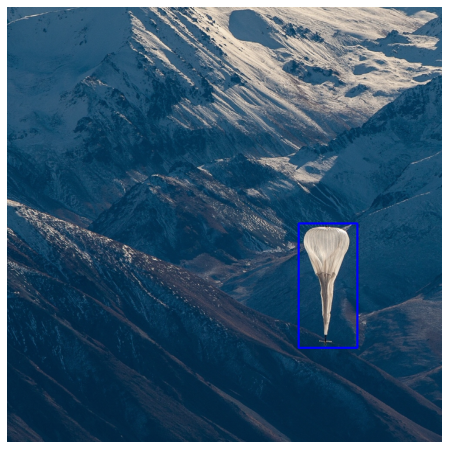

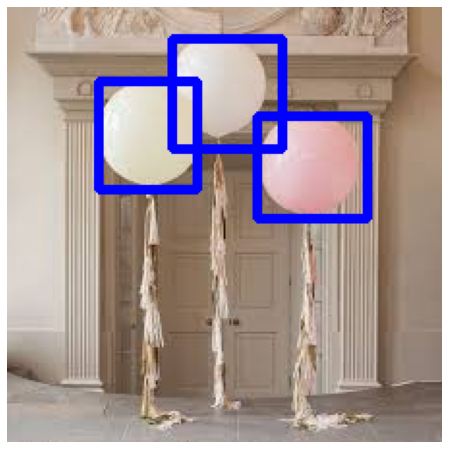

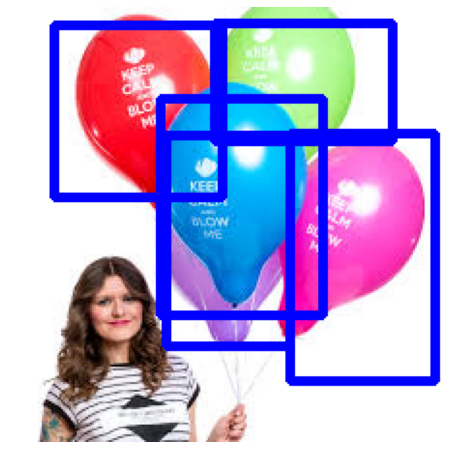

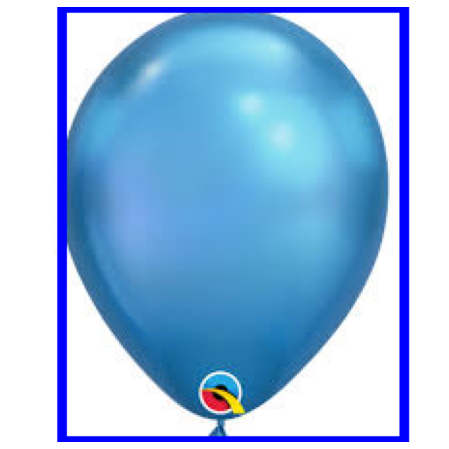

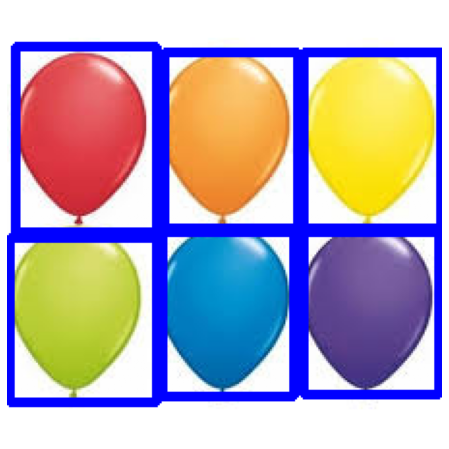

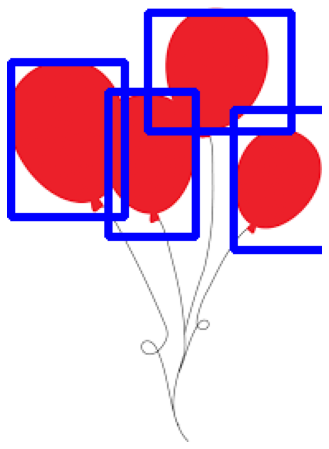

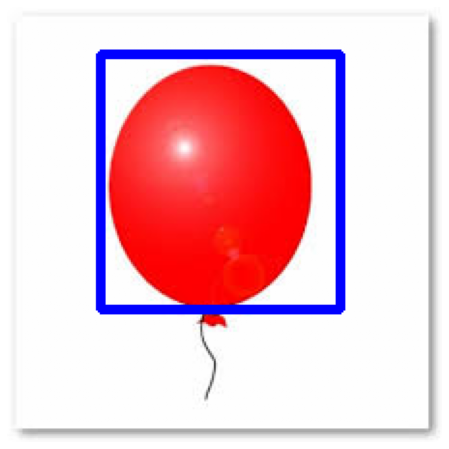

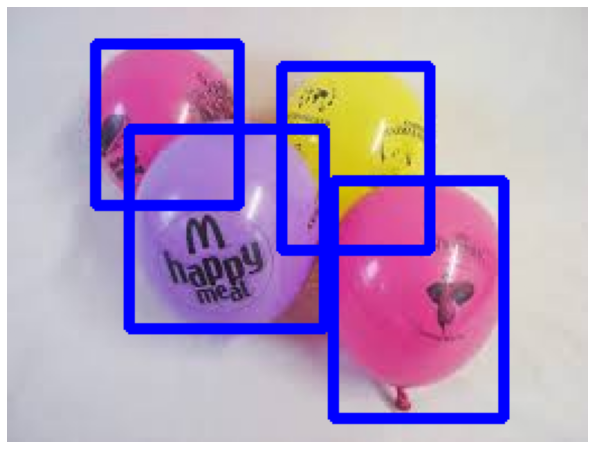

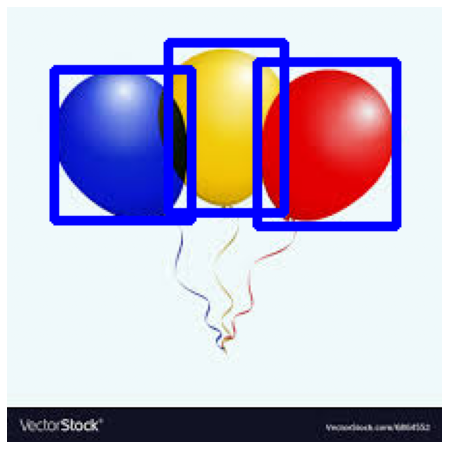

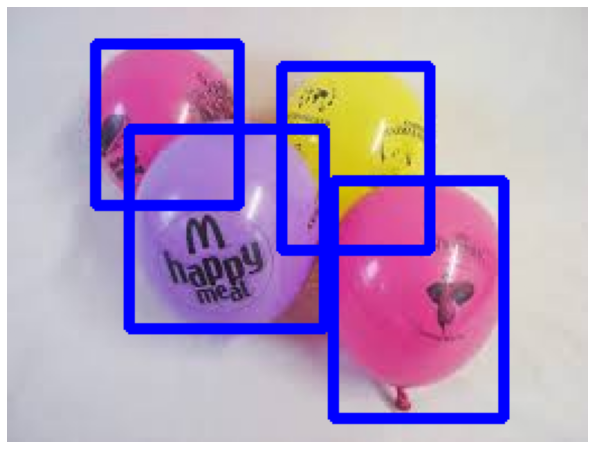

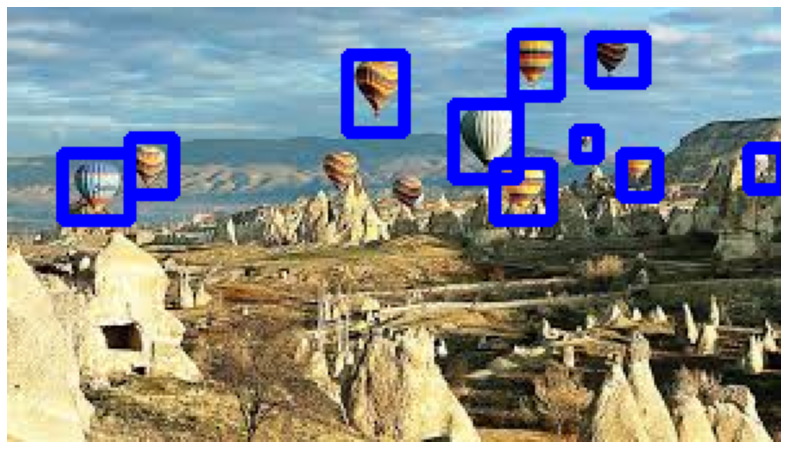

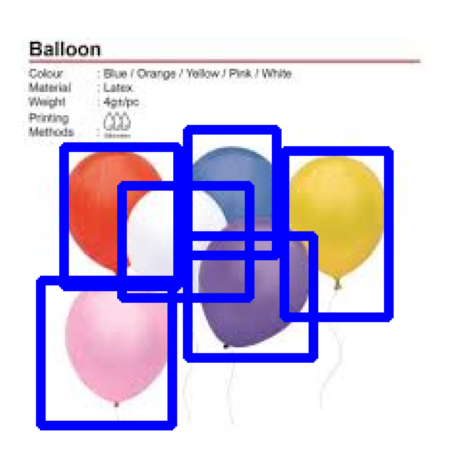

In [52]:
import scipy.misc
from PIL import Image

targets =[]

#file_num = df[df['#filename']=='new_002.jpg'].index[0] #2,5,13,20 #2
#file_nums =[file_num]


#file_nums =[1,15,20,30]
file_nums =[6,7,10,15,16,22,32,36,1,35,40,65]
#file_nums =[35,45,50,55,60]
for file_num in file_nums:
    img_path =path +df['#filename'][file_num]
    #print(df[df['#filename'] == df['#filename'][file_num]][['#filename','x','y','w','h']])
    #print('image_path->',img_path)
    #box_true=make_true_boxes(df,file_num)
    #box_true
    box_true=make_true_boxes(df,file_num)
    #print('box_true->',box_true)
    targets = box_true
    #print('img_path->',img_path)
    image_show(img_path,file_num,df,box_true,True,input_size)

# model predicct

/home/jake/venv/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


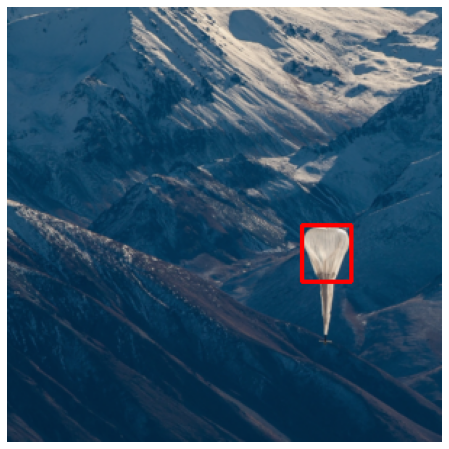

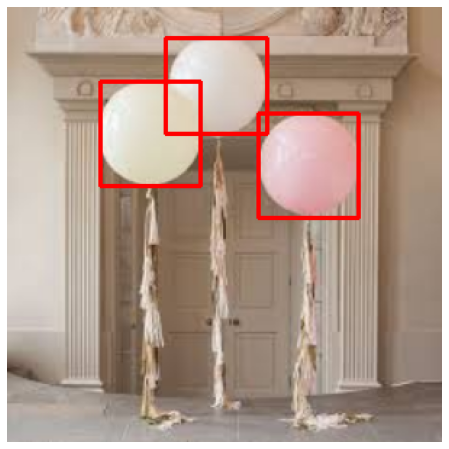

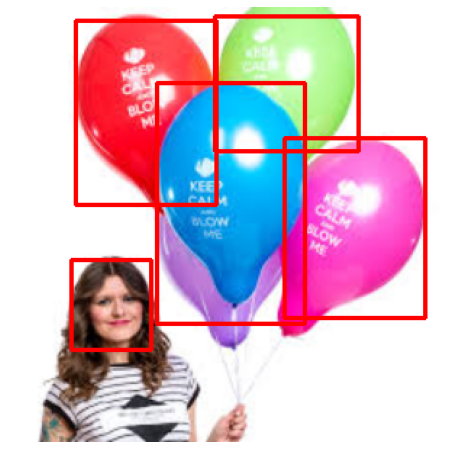

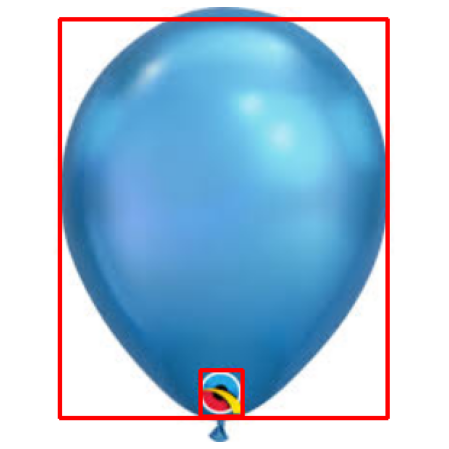

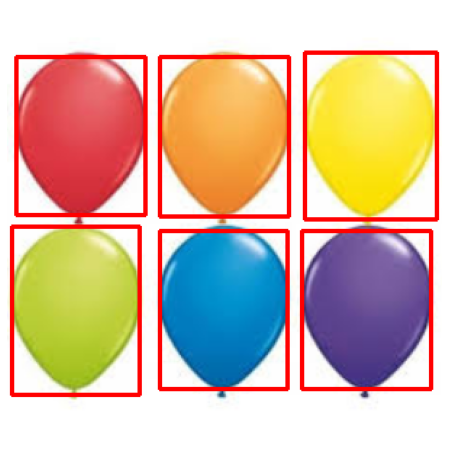

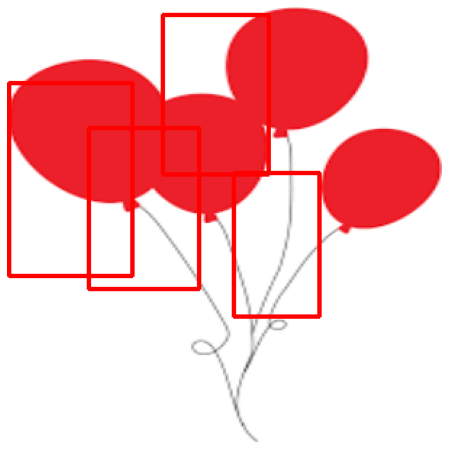

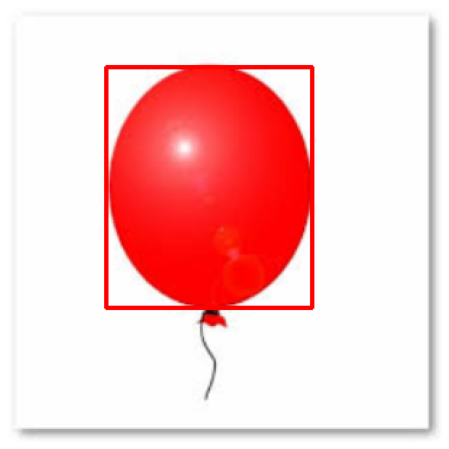

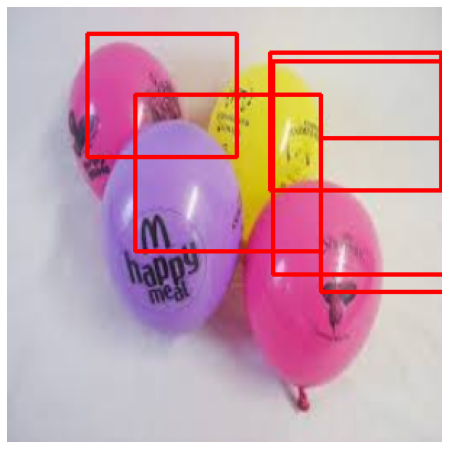

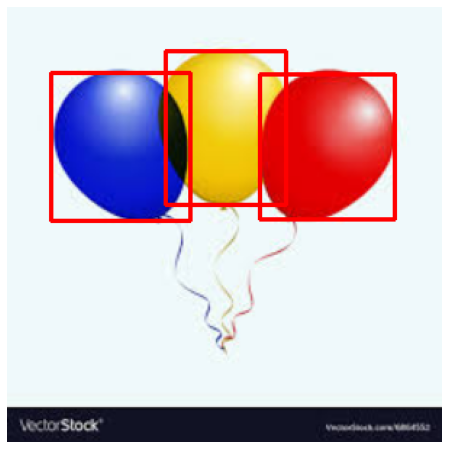

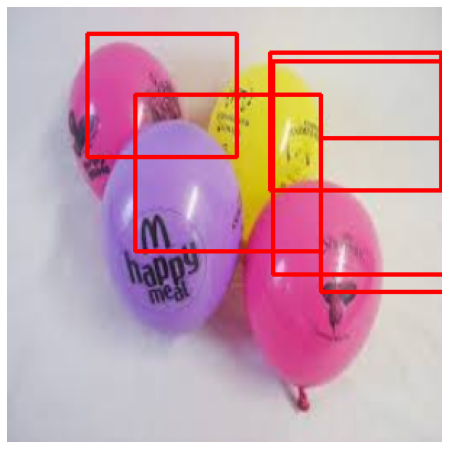

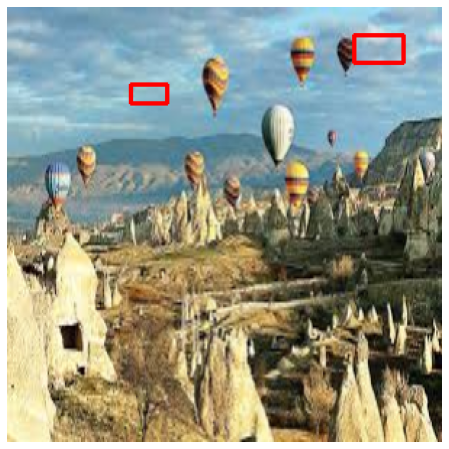

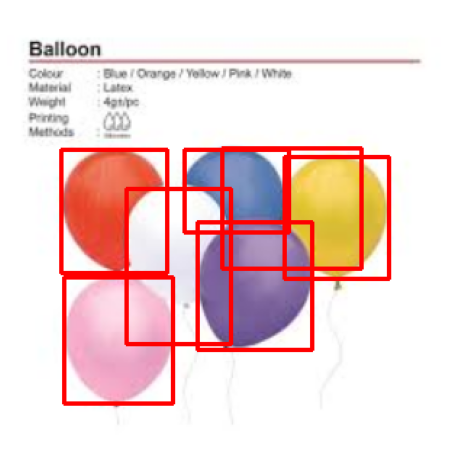

In [53]:
boxes_pred = []
confidences =[]
for file_num in file_nums:
    img_path =path +df['#filename'][file_num]
    #print('image_path->',img_path)
    #print('img_path->',img_path)
    image_arr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_arr /= 255.0
    
    #new_image_model = make_input_image(img_path, input_size=300)
    #print('image_arr.shape->',np.array(image_arr).shape)
    #print('new_image_model.shape->',np.array(new_image_model.cpu()).shape)

    model =torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    checkpoint = torch.load(weight_path)
    #print('weight_path-?>',weight_path)
    model.load_state_dict(checkpoint['state_dict'])
    epoch = checkpoint['epoch']
    model.cuda()

    new_image_model = FT.to_tensor(np.array(image_arr)).cuda()
    
    model.eval()
    outputs = model([new_image_model])
    outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]
    confidences = outputs[0]['scores']
    boxes_pred = outputs[0]['boxes']

    #print('box_pred->',boxes_pred)
    #boxes_pred = boxes_pred
    #print('confidences->',confidences)
    threshold = 0.5
    boxes_pred = boxes_pred[confidences > threshold]
    confidences = confidences[confidences > threshold]

    #print(boxes_pred)
    #print(confidences)
    #print(len(boxes_pred))
    image_show(img_path,file_num,df,boxes_pred,False,input_size)

In [202]:
boxes_pred = boxes_pred.cpu()
#boxes_pred = np.array(boxes_pred)
boxes_pred

tensor([[124.3959,  32.8083, 203.6433, 110.3429],
        [ 19.8934,  31.7756,  95.1475, 105.8972],
        [ 78.4987,  19.1418, 144.2476, 103.3049]], grad_fn=<IndexBackward>)

In [196]:
box_true

tensor([[ 24.,  32.,  95., 110.],
        [ 83.,  18., 143., 106.],
        [129.,  28., 201., 113.]], dtype=torch.float64)

In [197]:
confidences = confidences.detach().numpy()
#confidences = np.array(confidences)
print(confidences)

[0.9993987  0.99548715 0.99458766]


In [198]:
score = calculate_mean_precision(boxes_true=targets, boxes_pred=boxes_pred, confidences=confidences)
score

1.0

In [199]:
def make_input_image(img_path,input_size):
    image_arr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_arr /= 255.0
    new_image = image_arr

    new_image = FT.to_tensor(new_image)
    new_image = FT.to_pil_image(new_image)
    new_image = FT.resize(new_image, (input_size, input_size))
    new_image = FT.to_tensor(new_image)
    new_image = FT.to_pil_image(new_image)
    new_image_model = FT.to_tensor(np.array(new_image)).cuda()
    return new_image_model


def calculate_precision(boxes_true: torch.tensor, boxes_pred: torch.tensor, confidences: list, threshold=0.5) -> float:
    """Calculates precision for GT - prediction pairs at one threshold."""
    #print('boxes_true->',boxes_true)
    confidences = np.array(confidences)

    # edge case for no ground truth boxes
    #print('calculate_precision_boxes_true->',boxes_true)
    if boxes_true.size(1) == 0:
    
        return 0.

    #print('boxes_pred',boxes_pred.cpu())
    #print('boxes_true',boxes_true.cpu())
    #boxes_pred.cpu()
    #boxes_true.cpu()
    #print('boxes_pred->',boxes_pred)
    #print('boxes_true->?',boxes_true)
    iou = box_iou(boxes1=boxes_pred, boxes2=boxes_true)

    pr_matches = set()
    gt_matches = set()

    # for each ground truth box, get list of pred boxes it matches with
    match_candidates = (iou >= threshold).nonzero()
    GT_PR_matches = defaultdict(list)
    for PR, GT in match_candidates:
        GT_PR_matches[GT.item()].append(PR.item())

    # Find which pred matches a GT box
    for GT, PRs in GT_PR_matches.items():
        # if multiple preds match a single ground truth box,
        # select the pred with the highest confidence
        if len(PRs) > 1:
            pr_match = PRs[confidences[PRs].argsort()[-1]]
        # else only a single pred matches this GT box
        else:
            pr_match = PRs[0]

        # only if we haven't seen a pred before can we mark a PR-GT pair as TP
        # otherwise the pred matches a different GT box and this GT might instead be a FN
        if pr_match not in pr_matches:
            gt_matches.add(GT)

        pr_matches.add(pr_match)

    TP = len(pr_matches)

    pr_idx = range(iou.size(0))
    gt_idx = range(iou.size(1))

    FP = len(set(pr_idx).difference(pr_matches))
    FN = len(set(gt_idx).difference(gt_matches))

    return TP / (TP + FP + FN)


def calculate_mean_precision(boxes_true: torch.tensor, boxes_pred: torch.tensor, confidences: np.array,
                             thresholds=(0.5,)):
    """Calculates average precision over a set of thresholds"""

    precision = np.zeros(len(thresholds))

    for i, threshold in enumerate(thresholds):
        precision[i] = calculate_precision(boxes_true=boxes_true, boxes_pred=boxes_pred, confidences=confidences,
                                           threshold=threshold)
    return precision.mean()